# Probabilistic Methods (Discrete)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env

### Wrangle

In [2]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [3]:
# Synthetic data
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)

In [4]:
df['size_mb'] = df['size'] / 1024 / 1024
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')

## Detecting Anomalies in Discrete Variables

- **count**: the number of times each unique value appears in the dataset
- **frequencies**: the number of times each unique value appears in the dataset as a percentage of the total; the count divided by the total number of observations

In [5]:
df.ip.value_counts()

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
24.26.242.9          21
52.87.230.102         2
70.121.214.34         2
35.175.171.137        2
3.92.201.136          1
54.145.52.184         1
34.229.70.250         1
54.172.14.223         1
95.31.18.119          1
34.207.64.242         1
97.105.15.120         1
95.31.16.121          1
45.23.250.16          1
3.88.129.158          1
52.91.30.150          1
35.174.209.2          1
52.90.165.200         1
Name: ip, dtype: int64

In [6]:
df.ip.value_counts(normalize=True)

97.105.19.58      0.858420
173.173.113.51    0.075762
72.181.113.170    0.043855
72.181.105.81     0.017599
68.201.219.223    0.001502
24.26.242.9       0.001502
52.87.230.102     0.000143
70.121.214.34     0.000143
35.175.171.137    0.000143
3.92.201.136      0.000072
54.145.52.184     0.000072
34.229.70.250     0.000072
54.172.14.223     0.000072
95.31.18.119      0.000072
34.207.64.242     0.000072
97.105.15.120     0.000072
95.31.16.121      0.000072
45.23.250.16      0.000072
3.88.129.158      0.000072
52.91.30.150      0.000072
35.174.209.2      0.000072
52.90.165.200     0.000072
Name: ip, dtype: float64

In [7]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

In [8]:
ip_df = value_counts_and_frequencies(df.ip)
ip_df.head()

,count,proba
97.105.19.58,11999,0.858420
173.173.113.51,1059,0.075762
72.181.113.170,613,0.043855
72.181.105.81,246,0.017599
68.201.219.223,21,0.001502


From here we can find how many unique ip addresses there are:

<AxesSubplot:>

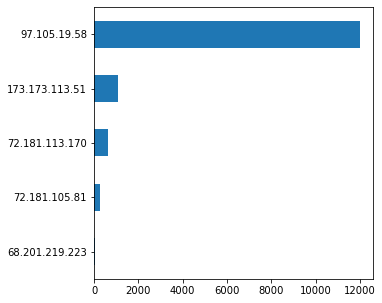

In [9]:
ip_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 5))

### Conditional Probabilities

HTTP Status Codes

- 200: ok
- 3xx: redirects
- 4xx: client level errors -- the requester did something wrong
- 5xx: server level errors -- the server did something wrong

In [10]:
status_given_ip = (
    df.groupby('ip')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
status_given_ip.head()

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.0
1,24.26.242.9,200,1.0
2,3.88.129.158,200,1.0
3,3.92.201.136,200,1.0
4,34.207.64.242,200,1.0


In [11]:
df[df.ip == '173.173.113.51']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-17 01:31:30,173.173.113.51,GET,/api/v1/sales,HTTP/1.1,200,493905,python-requests/2.21.0,0.471025
2019-04-17 01:31:56,173.173.113.51,GET,/,HTTP/1.1,200,42,python-requests/2.21.0,0.000040
2019-04-17 01:31:59,173.173.113.51,GET,/documentation,HTTP/1.1,200,348,python-requests/2.21.0,0.000332
2019-04-17 01:32:16,173.173.113.51,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-17 01:33:35,173.173.113.51,GET,/api/v1/sales,HTTP/1.1,200,493905,python-requests/2.21.0,0.471025
...,...,...,...,...,...,...,...,...
2019-04-17 05:20:01,173.173.113.51,GET,/api/v1/sales?page=179,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246
2019-04-17 05:20:04,173.173.113.51,GET,/api/v1/sales?page=180,HTTP/1.1,200,510788,python-requests/2.21.0,0.487125
2019-04-17 05:20:07,173.173.113.51,GET,/api/v1/sales?page=181,HTTP/1.1,200,510317,python-requests/2.21.0,0.486676


In [12]:
status_given_ip[status_given_ip.proba_status_given_ip < 1]

,ip,status_code,proba_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
22,97.105.19.58,200,0.998833
23,97.105.19.58,499,0.001167


In [13]:
df[df.ip == '72.181.113.170'].sort_values(by='status_code')

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-17 02:12:07,72.181.113.170,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-17 03:41:59,72.181.113.170,GET,/api/v1/sales?page=112,HTTP/1.1,200,510142,python-requests/2.21.0,0.486509
2019-04-17 03:42:01,72.181.113.170,GET,/api/v1/sales?page=113,HTTP/1.1,200,511094,python-requests/2.21.0,0.487417
2019-04-17 03:42:03,72.181.113.170,GET,/api/v1/sales?page=114,HTTP/1.1,200,511291,python-requests/2.21.0,0.487605
2019-04-17 03:42:05,72.181.113.170,GET,/api/v1/sales?page=115,HTTP/1.1,200,510140,python-requests/2.21.0,0.486507
...,...,...,...,...,...,...,...,...
2019-04-17 03:28:08,72.181.113.170,GET,/api/v1/sales?page=101,HTTP/1.1,200,510509,python-requests/2.21.0,0.486859
2019-04-17 03:28:11,72.181.113.170,GET,/api/v1/sales?page=102,HTTP/1.1,200,512612,python-requests/2.21.0,0.488865
2019-04-17 03:52:08,72.181.113.170,GET,/api/v1/sales?page=183,HTTP/1.1,200,308243,python-requests/2.21.0,0.293963


* Cases where the probability is < 100%
* Status codes other than 200

In [14]:
status_given_ip[status_given_ip.status_code != '200']

,ip,status_code,proba_status_given_ip
18,72.181.113.170,499,0.003263
19,95.31.16.121,301,1.000000
21,97.105.15.120,301,1.000000
23,97.105.19.58,499,0.001167
